<a href="https://colab.research.google.com/github/gikirima/KlikBERT/blob/main/Multitask%20mBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers datasets scikit-learn --quiet

import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer, AutoModel, TrainingArguments, Trainer
import torch.nn as nn
from torch.utils.data import Dataset
import numpy as np
# from google.colab import drive

## ✅ 2. Baca Dataset

In [28]:
# drive.mount('/content/drive')

file_path = "https://raw.githubusercontent.com/gikirima/KlikBERT/refs/heads/main/KlikBERT_dataset.csv"  # ganti sesuai lokasi kamu
df = pd.read_csv(file_path)

# Cek struktur
print(df.columns)
print(df['clickbait_label'].unique())
print(df['kategori_berita'].unique())


Index(['isi', 'judul', 'url', 'kategori_berita', 'clickbait_label'], dtype='object')
['misleading' 'non clickbait' 'teasing' 'exaggeration']
['politik' 'kriminal' 'bisnis' 'kesehatan' 'entertainment' 'lingkungan'
 'sport' 'teknologi' 'lifestyle']


In [29]:
# drop columns yang tidak diperlukan
df = df[['judul', 'isi','clickbait_label', 'kategori_berita']]
df.drop_duplicates(inplace=True)

df = df.dropna(subset=['judul', 'isi', 'clickbait_label', 'kategori_berita'])
df.describe()

,judul,isi,clickbait_label,kategori_berita
count,4117,4117,4117,4117
unique,4116,2721,4,9
top,"Atasi Kabut Asap dari Indonesia, Malaysia Renc...",Beauty,misleading,lifestyle
freq,2,369,1030,822


In [30]:
# drop duplikat
df.drop_duplicates(subset=['judul', 'isi'], inplace=True)

In [31]:
# drop yang isinya kosong
df = df[df['judul'].str.strip() != '']
df = df[df['isi'].str.strip() != '']
df = df[df['clickbait_label'].str.strip() != '']
df = df[df['kategori_berita'].str.strip() != '']

In [32]:
df.shape

(4117, 4)

### ✅ 3. Label Encoding (6 Kelas)

In [33]:
le_clickbait = LabelEncoder()
le_kategori = LabelEncoder()
df["label_encoded"] = le_clickbait.fit_transform(df["clickbait_label"])
df["kategori_encoded"] = le_kategori.fit_transform(df["kategori_berita"])

print("Label setelah encoding:", df["label_encoded"].unique())
print("Kategori setelah encoding:", df["kategori_encoded"].unique())

print("Mapping label:", dict(zip(le_clickbait.classes_, le_clickbait.transform(le_clickbait.classes_))))
print("Mapping kategori:", dict(zip(le_kategori.classes_, le_kategori.transform(le_kategori.classes_))))


Label setelah encoding: [1 2 3 0]
Kategori setelah encoding: [6 3 0 2 1 5 7 8 4]
Mapping label: {'exaggeration': np.int64(0), 'misleading': np.int64(1), 'non clickbait': np.int64(2), 'teasing': np.int64(3)}
Mapping kategori: {'bisnis': np.int64(0), 'entertainment': np.int64(1), 'kesehatan': np.int64(2), 'kriminal': np.int64(3), 'lifestyle': np.int64(4), 'lingkungan': np.int64(5), 'politik': np.int64(6), 'sport': np.int64(7), 'teknologi': np.int64(8)}


### ✅ 4. Split Train/Val/Test

In [34]:
X = df[["judul", "isi"]]
y = df[["label_encoded", "kategori_encoded"]]

train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    X, y, test_size=0.3, stratify=df["label_encoded"], random_state=42
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=42
)

# 2. Ambil masing-masing kolom sebagai list string
train_judul = train_texts["judul"].tolist()
train_isi   = train_texts["isi"].tolist()
val_judul   = val_texts["judul"].tolist()
val_isi     = val_texts["isi"].tolist()

### ✅ 5. Tokenisasi IndoBERT

In [35]:
# Ganti model ke mBERT
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")
max_len = 512

# 3. Tokenisasi dua input (judul dan isi)
train_encodings = tokenizer(
    train_judul,
    train_isi,
    truncation=True,
    padding=True,
    max_length=max_len
)
val_encodings = tokenizer(
    val_judul,
    val_isi,
    truncation=True,
    padding=True,
    max_length=max_len
)

In [36]:
# bagi y menjadi dua label terpisah
train_clickbait_labels = train_labels["label_encoded"].tolist()
train_kategori_labels  = train_labels["kategori_encoded"].tolist()

val_clickbait_labels = val_labels["label_encoded"].tolist()
val_kategori_labels  = val_labels["kategori_encoded"].tolist()

### ✅ 6. PyTorch Dataset

In [37]:
class ClickbaitDataset(Dataset):
    def __init__(self, encodings, clickbait_labels, kategori_labels):
        self.encodings = encodings
        self.clickbait_labels = clickbait_labels
        self.kategori_labels = kategori_labels

    def __len__(self):
        return len(self.clickbait_labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["clickbait_labels"] = torch.tensor(self.clickbait_labels[idx], dtype=torch.long)
        item["kategori_labels"] = torch.tensor(self.kategori_labels[idx], dtype=torch.long)

        return item



train_dataset = ClickbaitDataset(train_encodings, train_clickbait_labels, train_kategori_labels)
val_dataset   = ClickbaitDataset(val_encodings, val_clickbait_labels, val_kategori_labels)


### ✅ 7. Bangun Model IndoBERT Kustom Multitask-learning

In [38]:
class IndoBERTClassifier(nn.Module):
    def __init__(self, model_name, num_clickbait_labels, num_kategori_labels):
        super(IndoBERTClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.3)
        hidden_size = self.bert.config.hidden_size

        self.num_clickbait_labels = num_clickbait_labels
        self.num_kategori_labels = num_kategori_labels

        self.clickbait_classifier = nn.Linear(hidden_size, num_clickbait_labels)
        self.kategori_classifier = nn.Linear(hidden_size, num_kategori_labels)

    def forward(self, input_ids, attention_mask, clickbait_labels=None, kategori_labels=None):
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = output.last_hidden_state[:, 0, :]  # [CLS]

        dropout_output = self.dropout(pooled_output)
        clickbait_logits = self.clickbait_classifier(dropout_output)
        kategori_logits = self.kategori_classifier(dropout_output)

        loss = None
        loss_clickbait = None
        loss_kategori = None
        if clickbait_labels is not None and kategori_labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss_clickbait = loss_fct(clickbait_logits.view(-1, self.num_clickbait_labels), clickbait_labels.view(-1))
            loss_kategori = loss_fct(kategori_logits.view(-1, self.num_kategori_labels), kategori_labels.view(-1))
            loss = loss_clickbait + loss_kategori # total loss bisa ditambahkan atau dibagi 2
        return {"loss": loss,
                "loss_clickbait": loss_clickbait,
                "loss_kategori": loss_kategori,
                "clickbait_logits": clickbait_logits,
                "kategori_logits": kategori_logits}


### ✅ 8. Trainer Setup dan Training

In [39]:
model = IndoBERTClassifier(
    "bert-base-multilingual-cased",
    num_clickbait_labels=len(le_clickbait.classes_),
    num_kategori_labels=len(le_kategori.classes_)
    )

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3, # learning rate yang umum digunakan, hyperparameter ini bisa disesuaikan
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_steps=50,
    save_steps=50,
    learning_rate=2e-5, # learning rate yang umum digunakan, hyperparameter ini bisa disesuaikan
    eval_strategy="steps",
    save_strategy="steps",
    save_total_limit=1,
    logging_dir="./logs",
    logging_steps=50,
    logging_strategy="steps",
    report_to="none",
    remove_unused_columns=False,
    metric_for_best_model="eval_loss", # Tentukan metrik untuk model terbaik
    load_best_model_at_end=True,     # Muat model terbaik di akhir training
    greater_is_better=False          # Karena metriknya loss, nilai lebih kecil lebih baik
)

# === Custom collate function ===
def custom_collate_fn(batch):
    return {
        "input_ids": torch.stack([item["input_ids"] for item in batch]),
        "attention_mask": torch.stack([item["attention_mask"] for item in batch]),
        "clickbait_labels": torch.tensor([item["clickbait_labels"] for item in batch]),
        "kategori_labels": torch.tensor([item["kategori_labels"] for item in batch]),

    }

# Custom Trainer untuk multi-task
class MultiTaskTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._last_logged_step = -1  # tracker untuk mencegah duplikasi lo

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        clickbait_labels = inputs.pop("clickbait_labels")
        kategori_labels  = inputs.pop("kategori_labels")
        outputs = model(**inputs, clickbait_labels=clickbait_labels, kategori_labels=kategori_labels)

        loss = outputs["loss"]

        current_step = self.state.global_step
        if self.is_in_train and current_step != self._last_logged_step:
            self._last_logged_step = current_step  # update tracker
            self.log({
                "loss_clickbait": outputs["loss_clickbait"].mean().item(),
                "loss_kategori": outputs["loss_kategori"].mean().item()
            })


        return (loss, outputs) if return_outputs else loss



trainer = MultiTaskTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=custom_collate_fn,
    # resume_from_checkpoint="./results/checkpoint-XXXX" # uncomment untuk resume training, ganti XXXX dengan step checkpoint terakhir
)

### ✅ 9. Jalankan Training

In [40]:
trainer.train()

Step,Training Loss,Validation Loss
50,2.997900,2.713094
100,2.623800,2.175656
150,2.052600,1.916884
200,1.965400,1.674922
250,1.790600,1.607987
300,1.632200,1.492497
350,1.597800,1.450106
400,1.408500,1.361127
450,1.300400,1.408662
500,1.325200,1.310434


TrainOutput(global_step=1083, training_loss=1.4127482610616218, metrics={'train_runtime': 3388.7406, 'train_samples_per_second': 2.551, 'train_steps_per_second': 0.32, 'total_flos': 0.0, 'train_loss': 1.4127482610616218, 'epoch': 3.0})

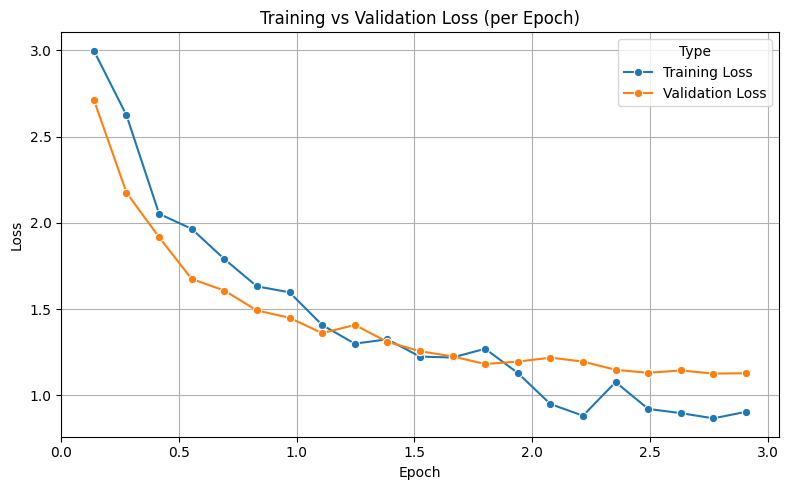

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ambil log history dari trainer
log_hist = trainer.state.log_history

# Konversi ke DataFrame
df_log = pd.DataFrame(trainer.state.log_history)

# Gunakan epoch daripada step
df_loss = df_log[df_log['epoch'].notna()][['epoch', 'loss', 'eval_loss']]
df_loss = df_loss.rename(columns={'epoch': 'Epoch'})

# Ubah ke format long agar bisa pakai sns.lineplot
df_melted = df_loss.melt(id_vars='Epoch',
                         value_vars=['loss', 'eval_loss'],
                         var_name='Type',
                         value_name='Loss')

# Rename label agar rapi
df_melted['Type'] = df_melted['Type'].replace({
    'loss': 'Training Loss',
    'eval_loss': 'Validation Loss'
})

# Plot pakai seaborn
plt.figure(figsize=(8, 5))
sns.lineplot(data=df_melted, x='Epoch', y='Loss', hue='Type', marker='o')
plt.title('Training vs Validation Loss (per Epoch)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.tight_layout()
plt.show()


<ipython-input-42-2752237855>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_loss.rename(columns={


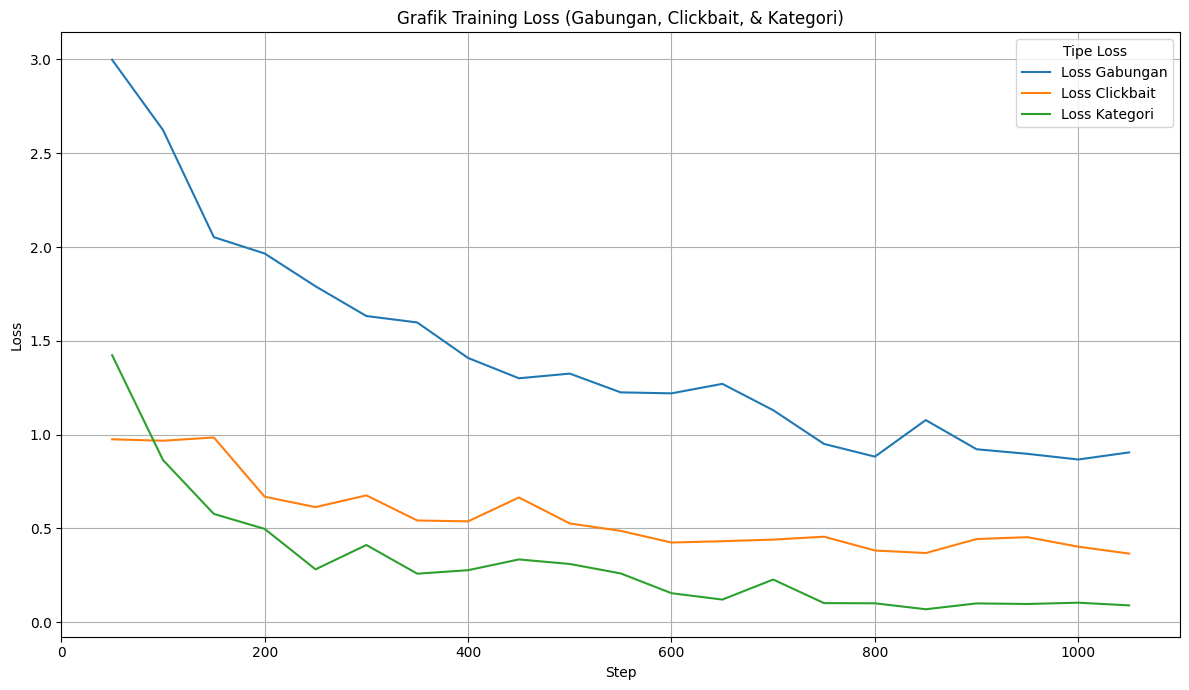

In [42]:
# --- KODE PERSIAPAN DATA BARU YANG LEBIH BAIK ---

# 1. Pilih hanya kolom yang kita perlukan
df_relevant = df_log[['step', 'loss', 'loss_clickbait', 'loss_kategori']].copy()

# 2. Kelompokkan berdasarkan 'step'. Untuk setiap step, ambil nilai non-kosong pertama
#    yang ditemukan untuk setiap jenis loss. Ini akan menggabungkan beberapa baris log
#    untuk step yang sama menjadi satu baris tunggal.
df_agg = df_relevant.groupby('step').agg({
    'loss': 'first',
    'loss_clickbait': 'first',
    'loss_kategori': 'first'
}).reset_index()

# 3. Buang baris yang datanya tidak lengkap (misalnya, log evaluasi yang tidak punya 'loss')
df_train_loss = df_agg.dropna()


# --- Sisa kode plotting tetap sama (tidak perlu diubah) ---

if df_train_loss.empty:
    print("Tidak ada data training loss yang bisa diplot. Pastikan training sudah berjalan.")
else:
    # Ubah nama kolom agar lebih rapi di legenda grafik
    df_train_loss.rename(columns={
        'loss': 'Loss Gabungan',
        'loss_clickbait': 'Loss Clickbait',
        'loss_kategori': 'Loss Kategori'
    }, inplace=True)

    # "Melt" dataframe agar bisa diplot dengan mudah oleh Seaborn
    df_melted = df_train_loss.melt(
        id_vars='step',
        value_vars=['Loss Gabungan', 'Loss Clickbait', 'Loss Kategori'],
        var_name='Tipe Loss',
        value_name='Nilai Loss'
    )

    # Buat plot (tanpa confidence interval)
    plt.figure(figsize=(12, 7))
    sns.lineplot(data=df_melted, x='step', y='Nilai Loss', hue='Tipe Loss', errorbar=None)
    plt.title('Grafik Training Loss (Gabungan, Clickbait, & Kategori)')
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [43]:
df_log.to_csv('history_log.csv', index=False)

### ✅ A. Evaluasi Model

In [44]:
from sklearn.metrics import classification_report, accuracy_score

# 1. Dapatkan prediksi dari data validasi
preds_output = trainer.predict(val_dataset)

# --- PERBAIKAN ---
# Model mengembalikan tuple berisi (loss_clickbait, loss_kategori, clickbait_logits, kategori_logits)
# Kita ambil logits dari indeks 2 dan 3.
all_preds_outputs = preds_output.predictions
pred_clickbait_logits = all_preds_outputs[2]
pred_kategori_logits  = all_preds_outputs[3]
# --- AKHIR PERBAIKAN ---

# Ambil prediksi masing-masing task:
pred_clickbait = torch.argmax(torch.tensor(pred_clickbait_logits), dim=1)
pred_kategori  = torch.argmax(torch.tensor(pred_kategori_logits), dim=1)

# Label ground-truth
labels_clickbait = torch.tensor([x["clickbait_labels"] for x in val_dataset])
labels_kategori  = torch.tensor([x["kategori_labels"] for x in val_dataset])

# Pisahkan logits
logits_clickbait = preds_output.predictions[0]
logits_kategori = preds_output.predictions[1]

all_kategori_labels = np.arange(len(le_kategori.classes_))

# 3. Evaluasi
print("✅ Classification Report:")
print(classification_report(labels_clickbait, pred_clickbait, target_names=le_clickbait.classes_, zero_division=0))
print(classification_report(labels_kategori, pred_kategori, labels=all_kategori_labels, target_names=le_kategori.classes_, zero_division=0))

# Evaluasi Kategori
print("📌 [Kategori]")
print("Accuracy:", accuracy_score(labels_kategori, pred_kategori))
# Evaluasi Clickbait
print("📌 [Clickbait]")
print("Accuracy:", accuracy_score(labels_clickbait, pred_clickbait))

✅ Classification Report:
               precision    recall  f1-score   support

 exaggeration       0.59      0.67      0.63       150
   misleading       0.89      0.80      0.84       146
non clickbait       0.89      0.81      0.85       161
      teasing       0.63      0.66      0.65       161

     accuracy                           0.74       618
    macro avg       0.75      0.74      0.74       618
 weighted avg       0.75      0.74      0.74       618

               precision    recall  f1-score   support

       bisnis       0.83      0.93      0.88        61
entertainment       0.87      0.90      0.88       122
    kesehatan       0.77      0.79      0.78        62
     kriminal       0.72      0.75      0.74        52
    lifestyle       0.82      0.81      0.81       109
   lingkungan       0.80      0.73      0.76        33
      politik       0.88      0.88      0.88        92
        sport       0.98      0.93      0.96        61
    teknologi       0.88      0.58  

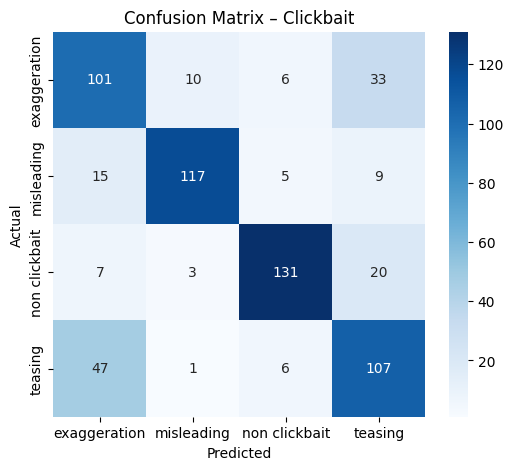

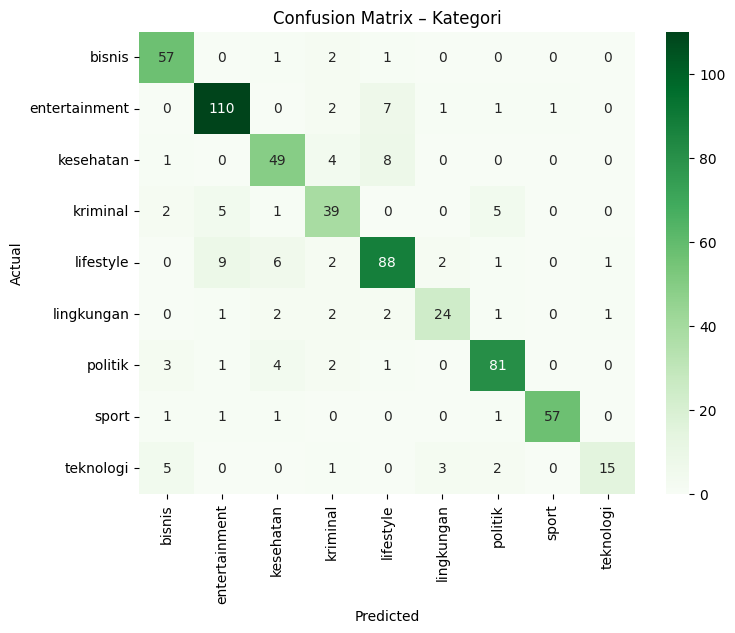

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion matrix untuk Clickbait
cm_clickbait = confusion_matrix(labels_clickbait, pred_clickbait)
plt.figure(figsize=(6,5))
sns.heatmap(cm_clickbait, annot=True, fmt="d", cmap="Blues",
            xticklabels=le_clickbait.classes_,
            yticklabels=le_clickbait.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Clickbait")
plt.show()

# Confusion matrix untuk Kategori
cm_kategori = confusion_matrix(labels_kategori, pred_kategori)
plt.figure(figsize=(8,6))
sns.heatmap(cm_kategori, annot=True, fmt="d", cmap="Greens",
            xticklabels=le_kategori.classes_,
            yticklabels=le_kategori.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Kategori")
plt.show()


### ✅ B. Simpan Model (format .bin)

In [46]:
import os

save_path = "./mBERT/"
os.makedirs(save_path, exist_ok=True)


simpan model dan tokenizer

In [47]:
# Simpan model
torch.save(model.state_dict(), os.path.join(save_path, "pytorch_model.bin"))

# Simpan tokenizer
tokenizer.save_pretrained(save_path)
model.bert.config.save_pretrained(save_path)